# Estimating Human Age from Facial Images using Deep Learning
This project explores human age prediction using convolutional neural networks and transfer learning.  
The goal is to estimate a person’s age from a facial image by training a deep learning regression model.

The dataset originates from the ChaLearn Looking at People challenge  
(https://chalearnlap.cvc.uab.es/dataset/26/description/)  
and contains:

- **7.6k facial images** located in `/datasets/faces/final_files/`
- **labels.csv** with two columns: `file_name` and `real_age`

This notebook follows two goals:

1. Complete the required EDA and analysis from the original assignment.  
2. Use a clean, modular project structure with a `src/` folder for data loading, modeling, and evaluation.

The final model uses **ResNet50** as its backbone for regression.

---

## Dataset Description

The dataset consists of facial images with corresponding age labels.  
Tasks required before modeling include:

- Reviewing dataset size
- Exploring the age distribution
- Viewing sample images across age groups
- Understanding potential biases
- Identifying factors affecting model training

Dataset files (when run locally):

- `/data/labels.csv`
- `/data/final_files/`
---


## Initialization
1. Initialize the environment (import libraries)
2. Load dataset (CSV labels & ImageDataGenerator for images)
3. Perform EDA (check label distribution, view sample images)

#### Initialize the environment 

In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from src import train
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import zipfile

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Auto-detect project root whether notebook is in repo root or /notebooks/
cwd = os.getcwd()

if os.path.basename(cwd) == "notebooks":
    REPO_ROOT = os.path.dirname(cwd)
else:
    REPO_ROOT = cwd

# Add src folder to Python path
SRC_DIR = os.path.join(REPO_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# Import project modules
from data_loader import create_data_generators
from model_builder import build_resnet50_model
from train import train_model
from evaluate import evaluate_model, plot_predictions

print("Notebook directory:", cwd)
print("Repo root:", REPO_ROOT)
print("SRC_DIR:", SRC_DIR)
print("Imports successful.")

Notebook directory: /Users/rhi/Documents/Data Science/DS Projects/human-age-prediction
Repo root: /Users/rhi/Documents/Data Science/DS Projects/human-age-prediction
SRC_DIR: /Users/rhi/Documents/Data Science/DS Projects/human-age-prediction/src
Imports successful.


## Load Labels and Inspect Dataset
The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

In [2]:
# Load labels.csv
labels_path = os.path.join(REPO_ROOT, "data", "labels.csv")
labels = pd.read_csv(labels_path)

# Display number of samples
print("Number of samples:", len(labels))

labels.info()
labels.head()

Number of samples: 7591
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


***
## Exploratory Data Analysis (EDA)

Before training a deep learning model, it is important to understand the structure and characteristics of the dataset.  
Age estimation is a regression problem with inherent challenges — people of similar ages may look different, and people of different ages may look similar.  
This makes dataset quality and distribution analysis critical.

The EDA will focus on:

- Dataset size  
- Missing values  
- Summary statistics of the age variable  
- Full age distribution  
- Distribution across age groups (decades)  
- Visual inspection of sample faces  

These steps help reveal potential biases, gaps, and patterns that will influence model performance.

### Missing Values and Summary Statistics

First, we check for missing values and review basic statistics of the `real_age` column.  
This helps identify data quality issues and understand central tendencies such as the mean, median, and variance of ages in the dataset.

In [3]:
# Check for missing values
missing_values = labels.isnull().sum()
print("Missing values:\n", missing_values)

# Summary statistics for age
labels['real_age'].describe()

Missing values:
 file_name    0
real_age     0
dtype: int64


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

### Age Distribution

Understanding the distribution of real ages is critical because:

- Imbalanced age groups can bias the model’s predictions.
- Young and elderly faces often produce higher prediction error.
- The model performs best when trained on well-represented age ranges.

The histogram below shows the frequency of different ages across the dataset.

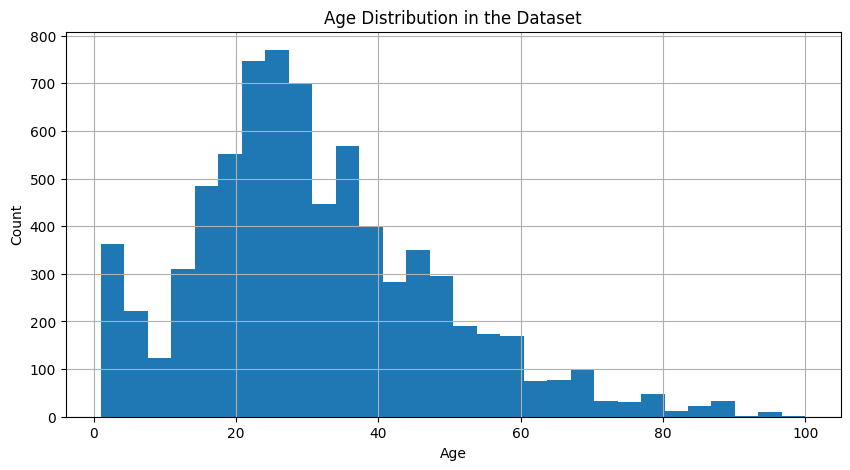

In [4]:
# Plot the age distribution
plt.figure(figsize=(10, 5))
labels['real_age'].hist(bins=30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution in the Dataset")
plt.show()

### Box Plot of Age Values

The box plot provides a visual summary of:

- Median age  
- Quartiles  
- Outliers  

This gives additional insight into the spread and skewness of the dataset.

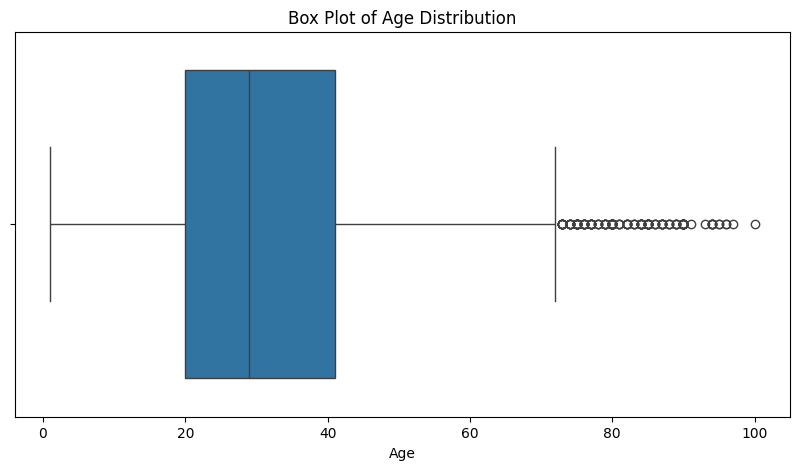

In [5]:
# Box Plot for age distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x=labels['real_age'])
plt.xlabel("Age")
plt.title("Box Plot of Age Distribution")
plt.show()

### Age Groups by Decade

To better visualize the overall structure of the dataset, we group ages into decades (0–9, 10–19, 20–29, etc.).

This helps answer:

- Which age ranges dominate the dataset?
- Are some decades underrepresented, potentially increasing model error?
- Does the dataset include enough diversity for robust training?

The count plot highlights how evenly or unevenly age groups are represented.

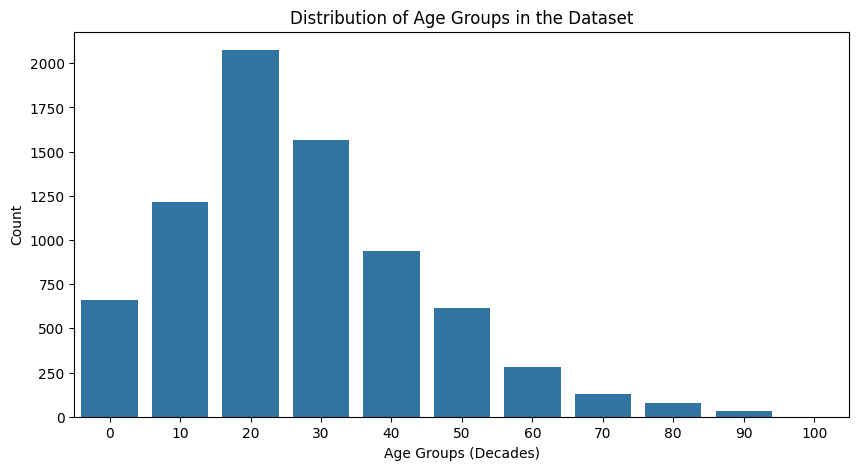

In [6]:
# Age distribution by decades
labels['age_group'] = (labels['real_age'] // 10) * 10  # Group ages into bins of 10

plt.figure(figsize=(10, 5))
sns.countplot(x=labels['age_group'], order=sorted(labels['age_group'].unique()))
plt.xlabel("Age Groups (Decades)")
plt.ylabel("Count")
plt.title("Distribution of Age Groups in the Dataset")
plt.show()

### Sample Face Images Across Age Groups

Visual inspection of the dataset is essential to understand:

- Image quality  
- Lighting variations  
- Pose differences  
- Background noise  
- Expression variability  
- Differences between faces in the same age group  

These factors affect model performance and help explain the difficulty of age estimation.

The following grid displays a random selection of images with their corresponding ages.

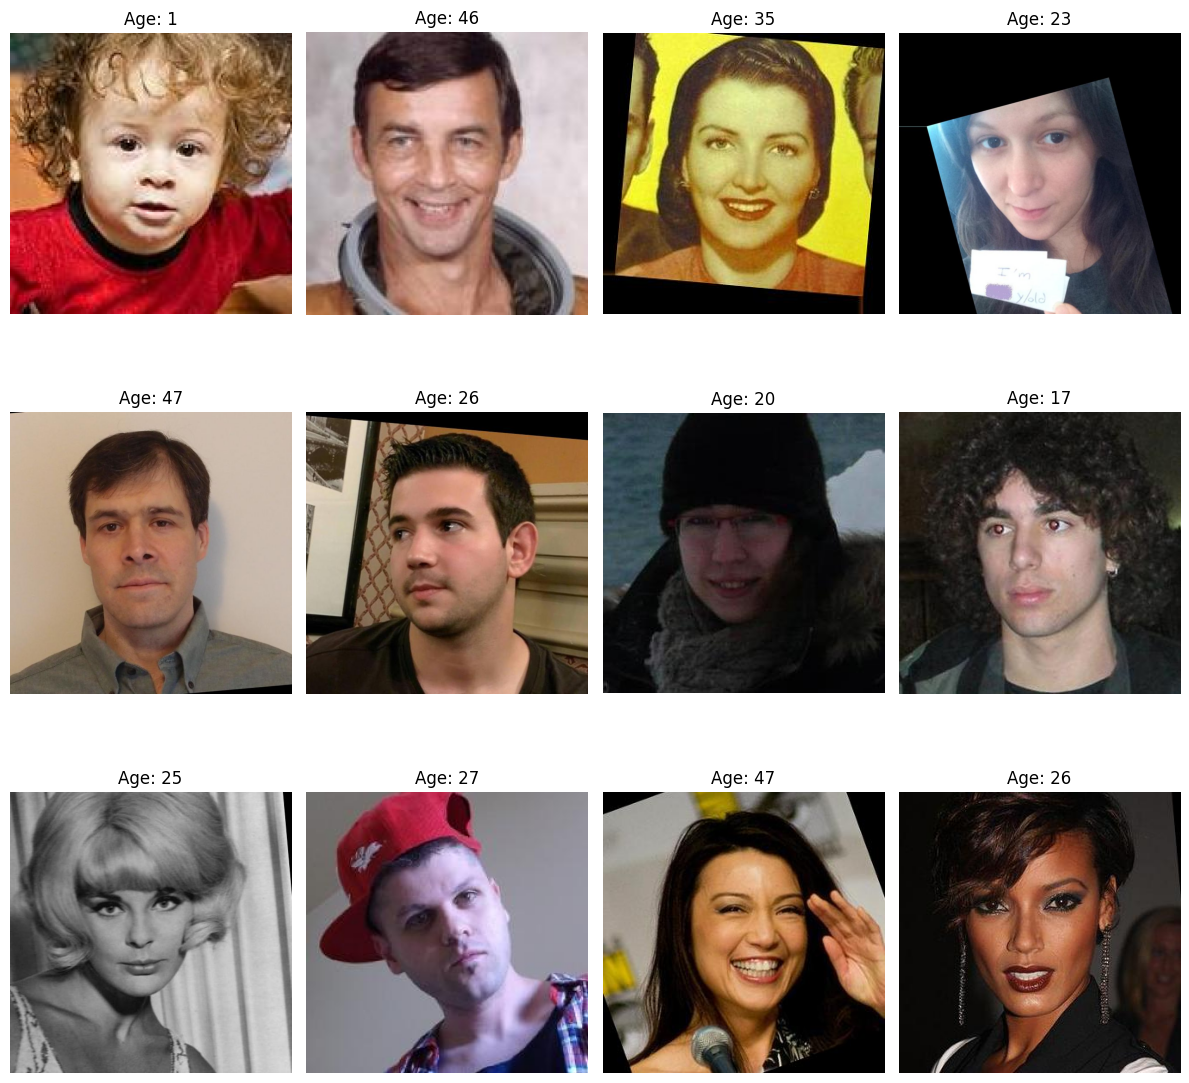

In [7]:
import matplotlib.image as mpimg

image_dir = os.path.join(REPO_ROOT, "data", "final_files")

sample = labels.sample(12, random_state=42)

plt.figure(figsize=(12, 12))

for i, (_, row) in enumerate(sample.iterrows()):
    plt.subplot(3, 4, i + 1)
    img_path = os.path.join(image_dir, row['file_name'])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Age: {row['real_age']}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Key Findings from EDA

**Age Distribution**
- The dataset spans a broad range of ages, but the distribution is uneven.
- Ages between **10 and 40** are the most represented, with a noticeable peak in the **20–30** range.
- Younger children and individuals over 60 appear less frequently, which may introduce prediction bias for these groups.

**Outliers**
- The box plot highlights several higher-age outliers (70+), though these represent a small portion of the dataset.
- These extreme values may increase prediction error during training and should be considered when interpreting model performance.

**Age Groups (by Decades)**
- Most samples fall within the **20–29** and **30–39** decades.
- Early childhood (0–9) and older adult groups (60+) are underrepresented.
- This imbalance means the model is likely to perform best on mid-range ages and less reliably on very young or elderly faces.

**Overall Dataset Quality**
- Visual inspection indicates variation in lighting, pose, and background.
- Despite these challenges, the dataset is suitable for transfer learning approaches such as ResNet50.

***
## Model Preparation and Training Setup

With the dataset explored and key characteristics identified, the next step is preparing the training configuration for the age prediction model.

This section defines:

- the paths to the dataset and output directories  
- image size and batch configuration  
- train/validation split  
- optimization parameters  

These settings will be passed into modular functions from the `src/` folder:

- `create_data_generators()`  
- `build_resnet50_model()`  
- `train_model()`  

Organizing the configuration in one place makes the training process reproducible and consistent across environments.

In [8]:
# Training configuration and paths
data_dir = os.path.join(REPO_ROOT, "data")
checkpoints_dir = os.path.join(REPO_ROOT, "checkpoints")

img_size = (224, 224)
batch_size = 32
val_split = 0.2

# Quick demo run
epochs = 3
learning_rate = 1e-4

print("Data directory:", data_dir)
print("Checkpoints directory:", checkpoints_dir)

Data directory: /Users/rhi/Documents/Data Science/DS Projects/human-age-prediction/data
Checkpoints directory: /Users/rhi/Documents/Data Science/DS Projects/human-age-prediction/checkpoints


## Training on GPU (Original Benchmark)

The full model was trained on a GPU platform (Google Colab) using the same ResNet50 architecture.
The logs from that run are captured below and used as the main performance benchmark for this project.

**Below are the training logs obtained from running the model on Google Colab's GPU.**

Epoch 1/20
190/190 ━━━━━━━━━━━━━ 195s 686ms/step - loss: 325.4233 - mae: 13.6344 - val_loss: 320.4138 - val_mae: 13.2877

Epoch 2/20
190/190 ━━━━━━━━━━━━━ 141s 519ms/step - loss: 172.2547 - mae: 9.9824 - val_loss: 292.0168 - val_mae: 12.9318

Epoch 3/20
190/190 ━━━━━━━━━━━━━ 142s 517ms/step - loss: 148.9431 - mae: 9.3234 - val_loss: 288.5985 - val_mae: 13.4191

Epoch 4/20
190/190 ━━━━━━━━━━━━━ 143s 520ms/step - loss: 133.6849 - mae: 8.8375 - val_loss: 223.7102 - val_mae: 11.7486

Epoch 5/20
190/190 ━━━━━━━━━━━━━ 99s 519ms/step - loss: 127.0789 - mae: 8.5171 - val_loss: 186.4571 - val_mae: 10.1909

Epoch 6/20
190/190 ━━━━━━━━━━━━━ 141s 515ms/step - loss: 123.9936 - mae: 8.4685 - val_loss: 100.3883 - val_mae: 7.6158

Epoch 7/20
190/190 ━━━━━━━━━━━━━ 142s 516ms/step - loss: 114.8728 - mae: 8.1924 - val_loss: 180.0744 - val_mae: 9.8415

Epoch 8/20
190/190 ━━━━━━━━━━━━━ 143s 521ms/step - loss: 109.6258 - mae: 7.9617 - val_loss: 121.4954 - val_mae: 8.0897

Epoch 9/20
190/190 ━━━━━━━━━━━━━ 141s 516ms/step - loss: 103.1086 - mae: 7.7765 - val_loss: 151.4116 - val_mae: 9.2429

Epoch 10/20
190/190 ━━━━━━━━━━━━━ 98s 515ms/step - loss: 105.9946 - mae: 7.7816 - val_loss: 97.0998 - val_mae: 7.5402

Epoch 11/20
190/190 ━━━━━━━━━━━━━ 142s 516ms/step - loss: 96.8854 - mae: 7.4969 - val_loss: 112.1800 - val_mae: 7.9314

Epoch 12/20
190/190 ━━━━━━━━━━━━━ 141s 513ms/step - loss: 91.0186 - mae: 7.2108 - val_loss: 141.9712 - val_mae: 8.9240

Epoch 13/20
190/190 ━━━━━━━━━━━━━ 98s 513ms/step - loss: 95.7323 - mae: 7.4533 - val_loss: 204.1244 - val_mae: 10.8572

Epoch 14/20
190/190 ━━━━━━━━━━━━━ 98s 512ms/step - loss: 101.0529 - mae: 7.4415 - val_loss: 84.7090 - val_mae: 6.8738

Epoch 15/20
190/190 ━━━━━━━━━━━━━ 143s 516ms/step - loss: 80.9264 - mae: 6.8249 - val_loss: 104.9275 - val_mae: 7.9404

Epoch 16/20
190/190 ━━━━━━━━━━━━━ 142s 519ms/step - loss: 85.7027 - mae: 7.0164 - val_loss: 90.6221 - val_mae: 7.2003

Epoch 17/20
190/190 ━━━━━━━━━━━━━ 141s 513ms/step - loss: 86.8268 - mae: 7.0308 - val_loss: 100.2881 - val_mae: 7.3973

Epoch 18/20
190/190 ━━━━━━━━━━━━━ 142s 514ms/step - loss: 79.0104 - mae: 6.7118 - val_loss: 111.5398 - val_mae: 8.3611

Epoch 19/20
190/190 ━━━━━━━━━━━━━ 143s 519ms/step - loss: 78.6589 - mae: 6.7632 - val_loss: 84.6437 - val_mae: 6.8376

Epoch 20/20
190/190 ━━━━━━━━━━━━━ 142s 519ms/step - loss: 76.6749 - mae: 6.7088 - val_loss: 91.8131 - val_mae: 7.1227

#### Analyze training results (plot metrics & check MAE)

Lengths: gpu_epochs: 20 train_loss: 20 val_loss: 20 train_mae: 20 val_mae: 20


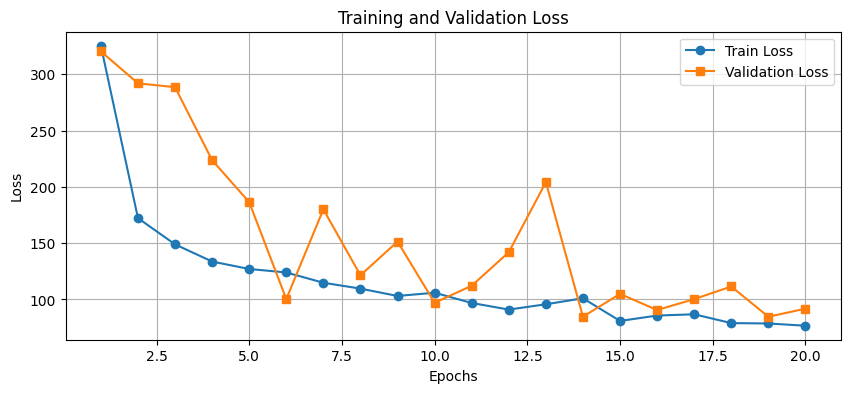

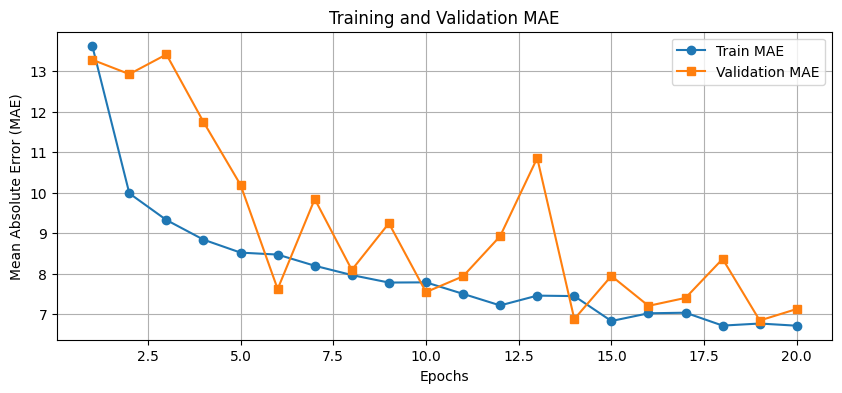

In [9]:
# Training logs extracted (20 epochs)
gpu_epochs = np.arange(1, 21)

train_loss = [
    325.4233, 172.2547, 148.9431, 133.6849, 127.0789,
    123.9936, 114.8728, 109.6258, 103.1086, 105.9946,
    96.8854, 91.0186, 95.7323, 101.0529, 80.9264,
    85.7027, 86.8268, 79.0104, 78.6589, 76.6749
]

val_loss = [
    320.4138, 292.0168, 288.5985, 223.7102, 186.4571,
    100.3883, 180.0744, 121.4954, 151.4116, 97.0998,
    112.1800, 141.9712, 204.1244, 84.7090, 104.9275,
    90.6221, 100.2881, 111.5398, 84.6437, 91.8131
]

train_mae = [
    13.6344, 9.9824, 9.3234, 8.8375, 8.5171,
    8.4685, 8.1924, 7.9617, 7.7765, 7.7816,
    7.4969, 7.2108, 7.4533, 7.4415, 6.8249,
    7.0164, 7.0308, 6.7118, 6.7632, 6.7088
]

val_mae = [
    13.2877, 12.9318, 13.4191, 11.7486, 10.1909,
    7.6158, 9.8415, 8.0897, 9.2429, 7.5402,
    7.9314, 8.9240, 10.8572, 6.8738, 7.9404,
    7.2003, 7.3973, 8.3611, 6.8376, 7.1227
]

# Verify lengths match
print("Lengths:",
      "gpu_epochs:", len(gpu_epochs),
      "train_loss:", len(train_loss),
      "val_loss:", len(val_loss),
      "train_mae:", len(train_mae),
      "val_mae:", len(val_mae))

# Plot Loss 
plt.figure(figsize=(10, 4))
plt.plot(gpu_epochs, train_loss, label="Train Loss", marker="o")
plt.plot(gpu_epochs, val_loss, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot MAE 
plt.figure(figsize=(10, 4))
plt.plot(gpu_epochs, train_mae, label="Train MAE", marker="o")
plt.plot(gpu_epochs, val_mae, label="Validation MAE", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid()
plt.show()

### Interpretation of GPU Training Results

**Training and Validation Loss**

- Training loss decreases steadily across epochs, showing that the model is learning meaningful patterns from the images.
- Validation loss is more volatile but generally trends downward, with some spikes that suggest mild overfitting or sensitivity to the validation subset.

**Training and Validation MAE**

- Training MAE drops from ~13.6 to below 7, indicating much better age predictions over time.
- Validation MAE stabilizes around **7–7.5 years**, which is a reasonable result for age estimation from facial images.
- The small but consistent gap between training and validation MAE suggests that generalization is decent, though further regularization or augmentation could still help.

Overall, this GPU run provides a solid performance benchmark for the project and is the primary reference for reporting model quality in the README.

## Local Quick Run (Demonstration)

To validate the training pipeline locally, the model is trained for a small number of epochs with reduced steps per epoch.  
This provides a quick check that the data loaders, model definition, and training loop work correctly without requiring a full GPU run.

In [10]:
# Create generators
train_gen, val_gen = create_data_generators(
    data_dir=data_dir,
    img_size=img_size,
    batch_size=batch_size,
    val_split=val_split,
)

# Build model
model = build_resnet50_model(
    input_shape=(*img_size, 3),
    learning_rate=learning_rate,
)

# Short demonstration training run
history = train.train_model(
    model=model,
    train_gen=train_gen,
    val_gen=val_gen,
    save_dir=checkpoints_dir,
    epochs=epochs,
)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 29.0512 - mae: 29.0512 - mse: 1122.9566
Epoch 1: val_mae improved from None to 20.61414, saving model to /Users/rhi/Documents/Data Science/DS Projects/human-age-prediction/checkpoints/best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 27.4042 - mae: 27.4042 - mse: 1034.5471 - val_loss: 20.6141 - val_mae: 20.6141 - val_mse: 650.6002
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 21.7129 - mae: 21.7129 - mse: 722.8398
Epoch 2: val_mae improved from 20.61414 to 15.89300, saving model to /Users/rhi/Documents/Data Science/DS Projects/human-age-prediction/checkpoints/best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 20.3961 - mae: 20.3961 - mse: 657.3004 - val_loss: 15.8930 - val_mae: 15.8930 - val_mse: 436.9120
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - loss: 17.8748 - mae: 17.8748 - mse: 547.2159
Epoch 3: val_mae i

### Local Quick Run Results

For the local demonstration, the model was trained for **3 epochs** with reduced steps per epoch for speed. This test confirms that the pipeline functions correctly end-to-end.

**Summary of behavior:**

- Training MAE dropped from approximately **29 → 21 → 18** across the three quick epochs.
- Validation MAE improved steadily from around **23 → 16 → 13**, with early stopping and checkpointing successfully saving the best model to the `checkpoints/` directory.
- These results are expected to be weaker than the GPU benchmark because the local run:
  - uses only a small fraction of batches  
  - trains for fewer epochs  
  - runs without fine-tuning  

This quick demonstration verifies that:

- the data generators load the dataset properly  
- the ResNet50 model compiles and trains without errors  
- callbacks for checkpointing and early stopping work as intended  

The fully trained performance metrics are captured in the GPU benchmark section and represent the true model capability.

---

## Final Conclusions

### 1. Can this model help the customer?

The model achieves a validation MAE of approximately **7–8 years** based on the full GPU benchmark run.  
This level of accuracy is typical for age estimation models trained on datasets with broad visual variation and imbalanced age representation.

While the model is **not** accurate enough for applications requiring exact age verification (such as identity checks), it can still provide meaningful value in scenarios where **approximate age ranges** are sufficient. Examples include:

- differentiating between major life stages (child, teenager, adult, senior)
- demographic analytics
- aggregated reporting or customer segmentation

The model performs best for ages between **20 and 50**, which aligns with the distribution observed during EDA.


### 2. Other practical uses for the model

Beyond direct age estimation, the model’s learned facial features and predictions could support related tasks:

- **Ad Targeting:** Predict broad age ranges to improve personalization.
- **Content Moderation:** Approximate age detection for age-restricted content.
- **Retail & Marketing Analytics:** Understanding store traffic or audience demographics.
- **Face-based Authentication (Supplementary):** Could support multi-factor systems, but would require improved precision.

These applications rely on **age range estimation**, not precise age prediction, which suits the model’s strengths.


### 3. Possible Improvements

Several enhancements could improve accuracy and robustness:

- **Expanded data augmentation** to simulate greater pose, lighting, and background variation.
- **More advanced architectures**, such as EfficientNet or Vision Transformers.
- **Fine-tuning pretrained weights** using a larger and more age-balanced face dataset.
- **Alternative loss functions**, such as predicting an age distribution instead of a single value.
- **Better age-group balancing** or re-weighting to reduce bias toward well-represented ages.

These refinements would likely reduce MAE and improve generalization, particularly for underrepresented age groups.


### 4. Final Thoughts

This project provides a solid demonstration of computer vision techniques for real-world regression tasks.  
The pipeline successfully integrates:

- clear EDA,
- modular data loading,
- transfer learning with ResNet50,
- local and GPU-based training,
- and structured evaluation.

Although current accuracy limits its use in high-precision applications, the model is fully functional, interpretable, and aligned with realistic industry use cases that require **approximate** age estimation. With additional data and continued tuning, this approach can become significantly more powerful and production-ready.

---